# Polymer-2 and Polymer-22 classification
This notebook contains the code for exploratory data analysis, preprocessing and modelling of the task of distinguishing between 1-bit polymers (with one bulky element) and 2-bit polymers (with two bulky elements)

In [2]:
%load_ext autoreload
%autoreload 2


## classic pydata stack
import os 
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestClassifier


%matplotlib inline 

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7)


import sys

import vanilla_NN as NN

sys.path.append('..')
from pipeline import *
from models import *



## Exploratory Data Analysis
Let's first dive into the data to get familiar with it and prepare for data processing. We are given 2 numpy files corresponding to 2 different polymer types (AA66266AA and AA662266AA), each file containing a list of sequences/events of *(timestamp, current)* pairs where each sequence represents an event of polymer going through a nanopore. Our data has a temporal nature and hence, relative current has been recorded at each timestep.

Let's first start loading the 2 files and check the shape and structure of the data.

In [3]:
polymer2 = np.load("../data/AA66266AA.npy",allow_pickle=True)
polymer22 = np.load("../data/AA662266AA.npy",allow_pickle=True)

In [4]:
polymer2.shape, polymer22.shape

((22039,), (50957,))

Let's try to get a feel at how our data looks like

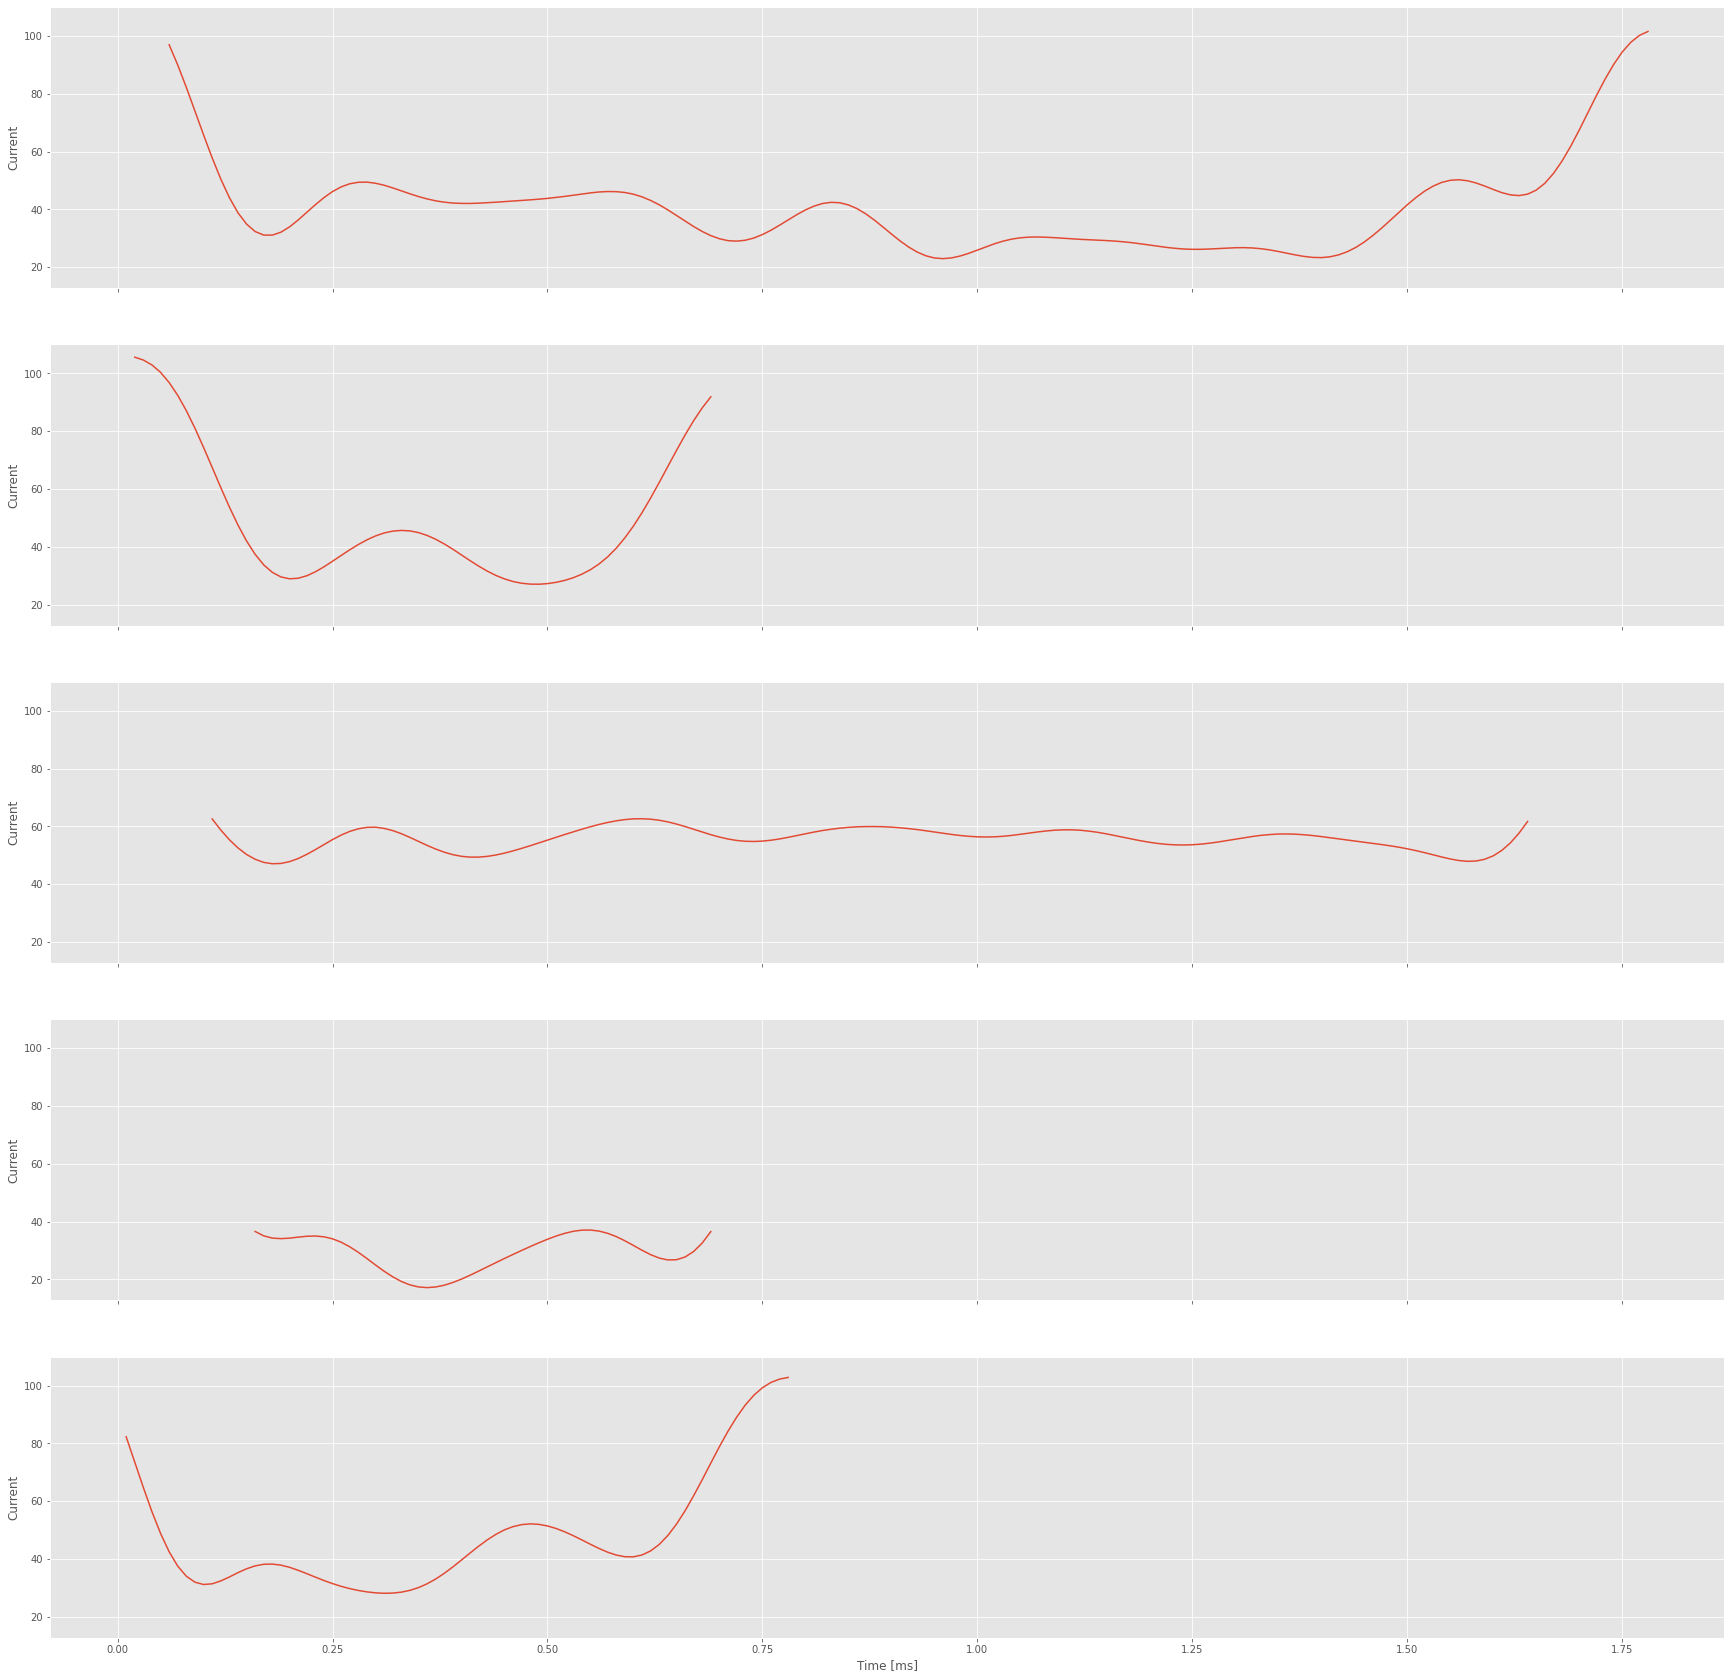

In [26]:
plot_data(polymer2[42:47])

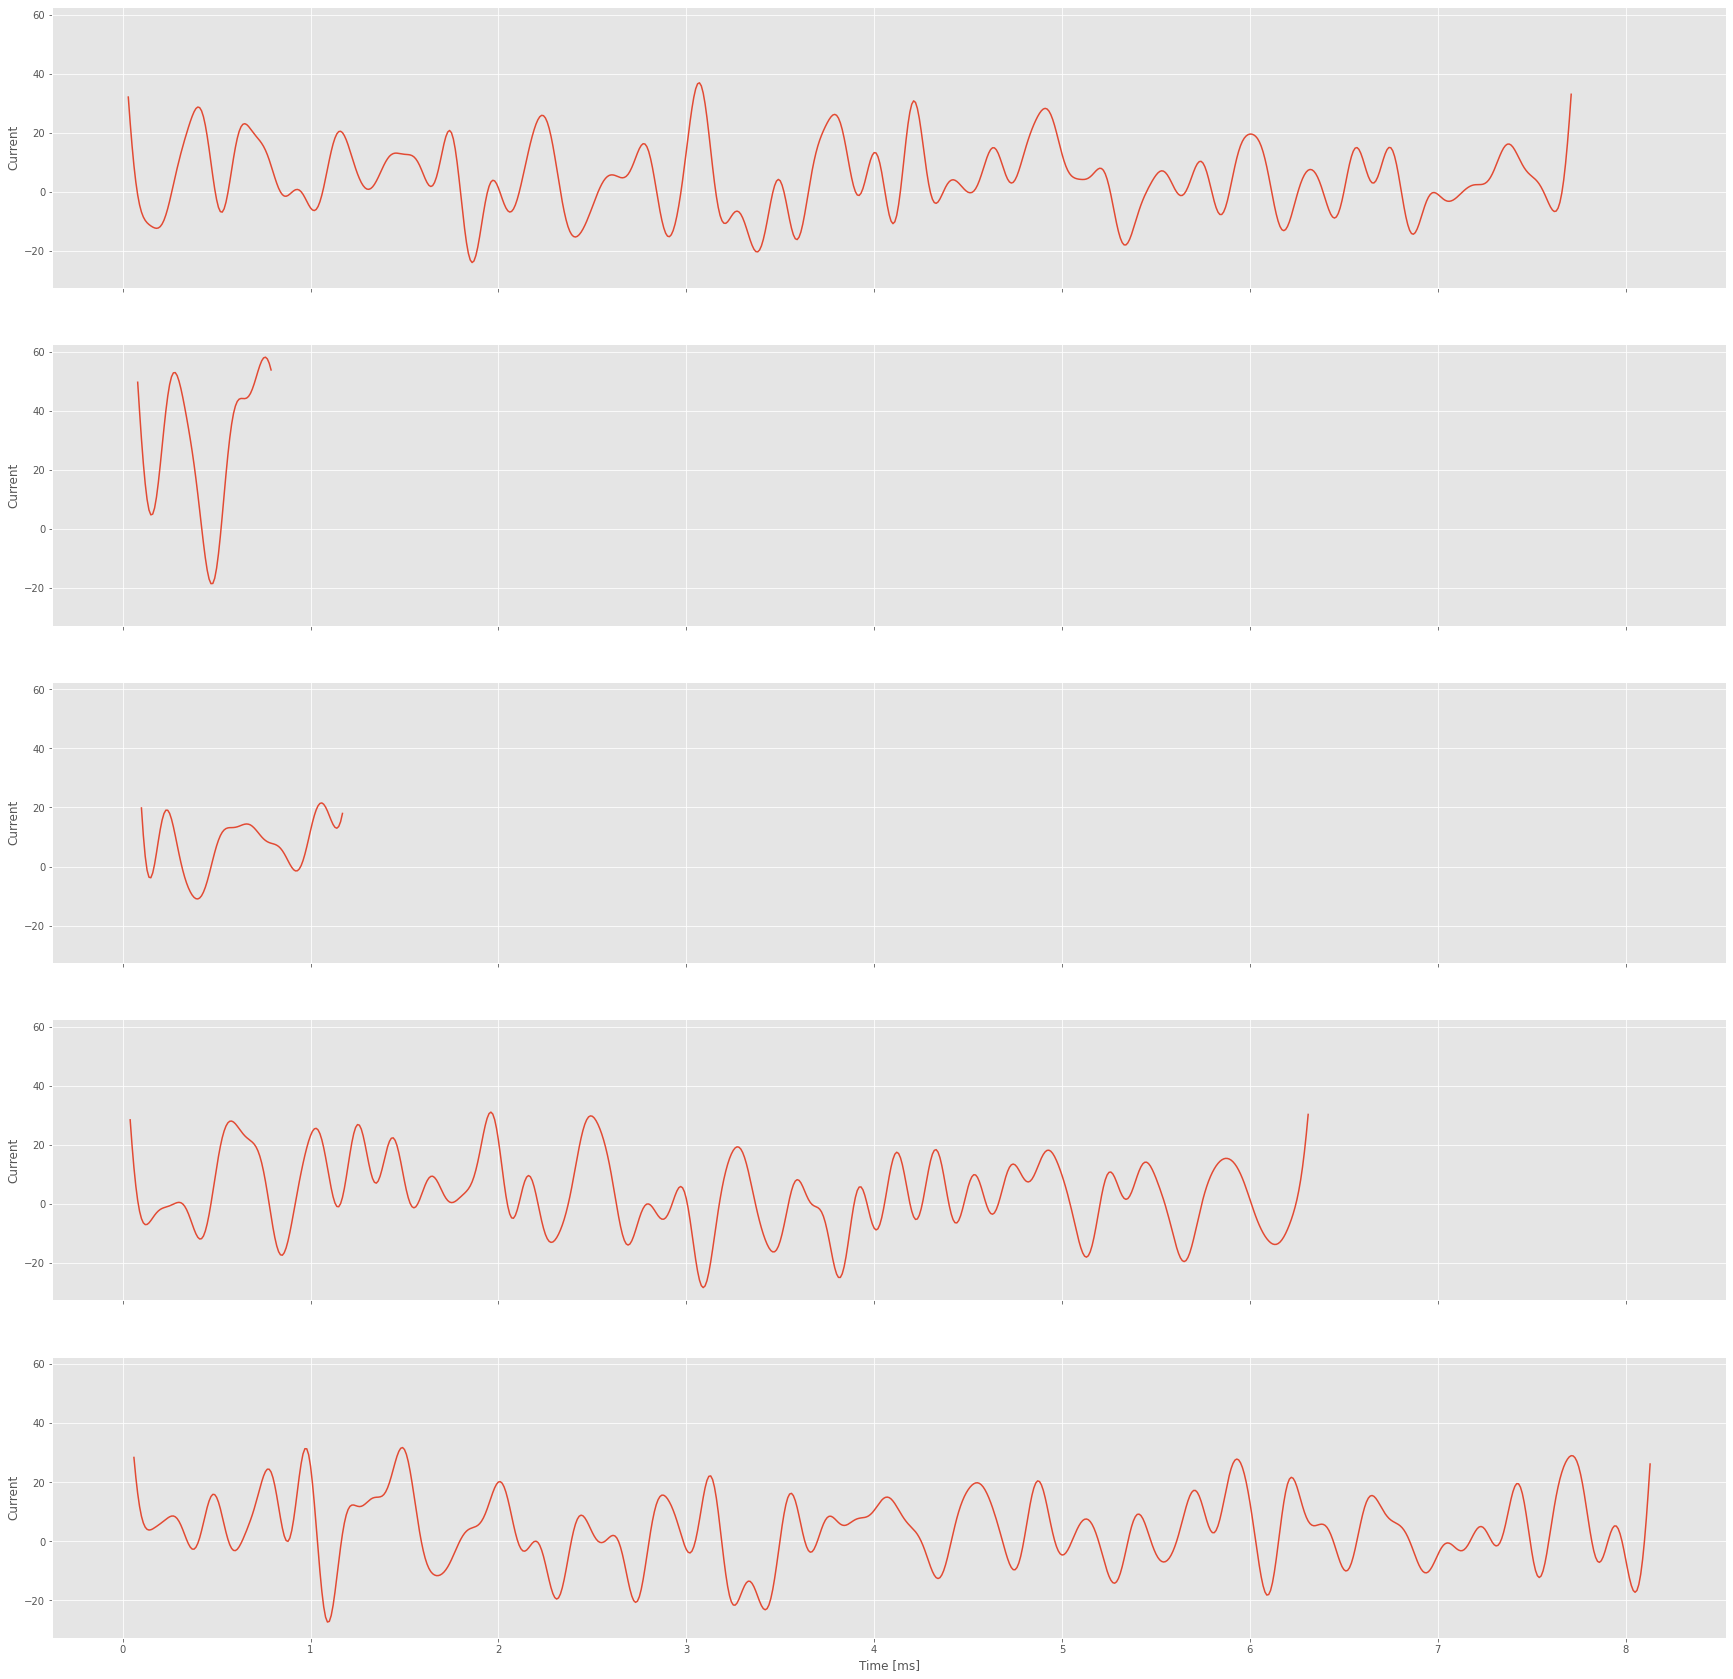

In [27]:
plot_data(polymer22[42:47])

Although it can be a bit hard to interpret what really is going on with those plots, we see that :
1. The lengths of the events are far from constant
2. The relative current in the second dataset tends to be really lower
3. The current appears to be more "noisy" in the second datset than in the first

Let's first explore our first observation

In [16]:
polymer2_event_lens = [len(event) for event in polymer2]
polymer22_event_lens = [len(event) for event in polymer22]

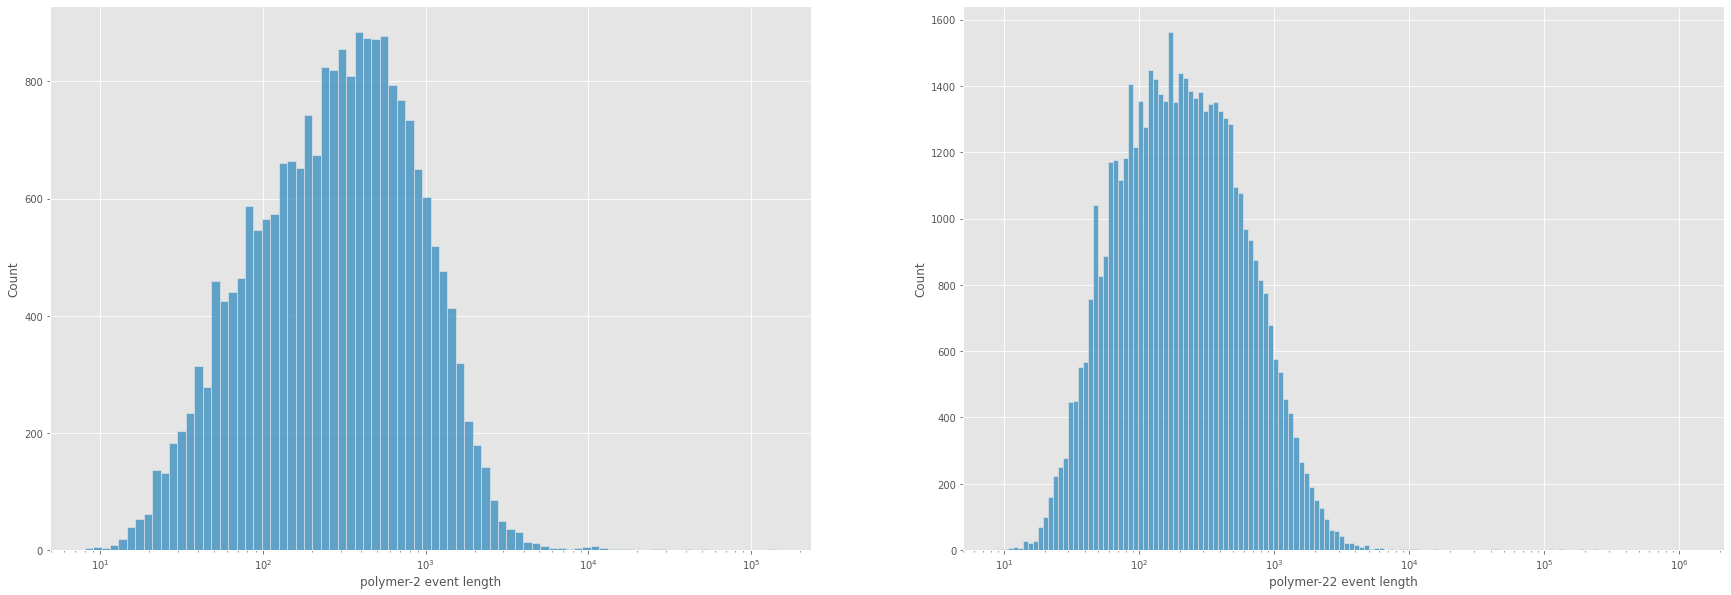

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
for ax, event_lens, ptype in zip(axes, [polymer2_event_lens, polymer22_event_lens], [2, 22]):
    ax.set_xlabel(f'polymer-{ptype} event length')
    sns.histplot(event_lens, ax=ax, log_scale=True)

In [20]:
np.mean(polymer2_event_lens),np.mean(polymer22_event_lens)

(506.773174826444, 476.0215083305532)

In [21]:
np.std(polymer2_event_lens),np.mean(polymer22_event_lens)

(1272.5643340000602, 476.0215083305532)

Surprisingly, the longer sequence tends to pass through the nanopore a bit quicker on average, and follow more closely its expected value (so less polymers getting stuck or going too quick).

Let's now discuss our other 2 observations

In [22]:
polymer2_currents = np.concatenate([event[:, 1] for event in polymer2])
polymer22_currents = np.concatenate([event[:, 1] for event in polymer22])


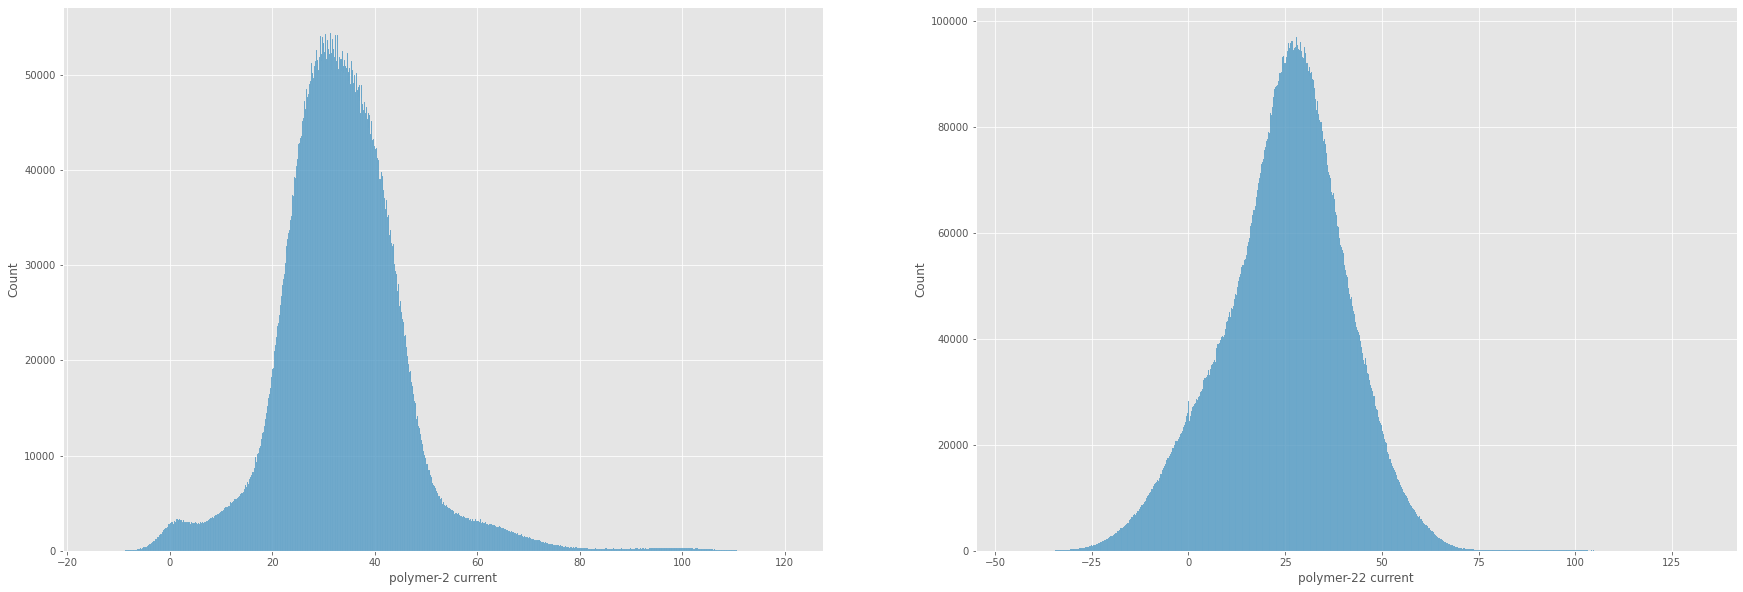

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
for ax, currents, ptype in zip(axes, [polymer2_currents, polymer22_currents], [2, 22]):
    ax.set_xlabel(f'polymer-{ptype} current')
    sns.histplot(currents, ax=ax)

In [24]:
np.mean(polymer2_currents),np.mean(polymer22_currents)

(33.589424, 24.884472)

In [25]:
np.std(polymer2_currents),np.std(polymer22_currents)

(12.18849, 15.973785)

It appears that our 2nd and 3rd observations were both correct, the longer sequences (with more bulky elements) tend to have a bigger standard deviation. This makes sense as the pore will be obstructed for longer, and thus have a lower relative current far from it's baseline mean, for longer.
We also see a little bump in the distribution of current around 0% for the shorter sequences. This could be explained as saturation in the sensor. 
There seems to be also more outlier on the right side of the distribution for the short sequence, but it is hard to make sense of it now.

Using what we've seen so far, let's try computing some very basic statistics for each dataset and see wether or not they would make great features

In [31]:
polymer_currents = [polymer2_currents, polymer22_currents]
polymers = [2, 22]
stats = ['mean', 'median', 'std', 'min', 'max']
polymer_stats = pd.DataFrame({
    'polymer': np.concatenate([[p] * len(stats) for p in polymers]),
    'stat': stats * len(polymers),
    'value': np.concatenate([[np.mean(currents), np.median(currents), np.std(currents), np.min(currents), np.max(currents)] for currents in polymer_currents])
})

<AxesSubplot:xlabel='stat', ylabel='value'>

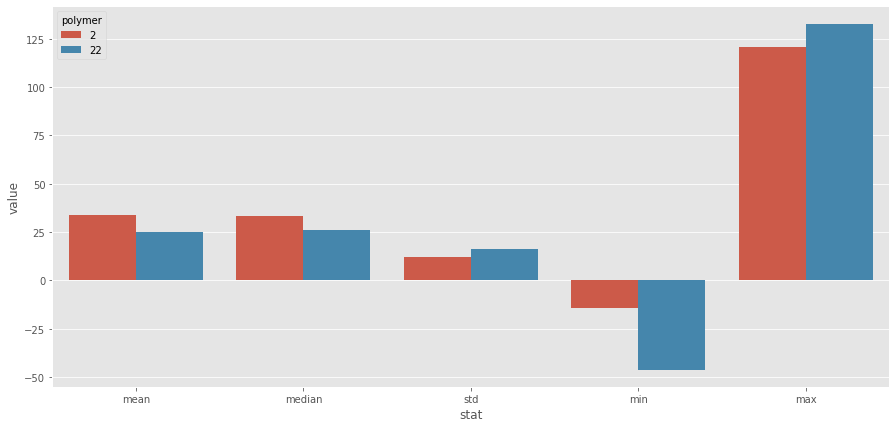

In [32]:
sns.barplot(data=polymer_stats, x='stat', y='value', hue='polymer')

As predicted, the lower current values could really help telling apart our polymers

## Feature Engineering and Data Preprocessing
For detailed explanations and great vizualisations of what we're doing here, please report to ../multi-class/polymer-245.ipynb

## Modelling

In [13]:
pipe = PairSingle_Pipeline(num_blocks=6)
dataset_fft = PolymerDataset(data_paths=["../data/AA66266AA.npy","../data/AA662266AA.npy"],pipeline=pipe)

Processing ../data/AA662266AA.npy: 100%|██████████| 17625/17625 [00:45<00:00, 385.52it/s]


In [14]:
train_data, test_data = train_test_split(dataset_fft)


In [15]:
model = PReLULSTM(input_dim=dataset_fft.num_features, output_dim=dataset_fft.num_classes, num_layers=1, hidden_dim=64)

In [16]:
model, test_metrics = train(train_data, model, batch_size=512, num_epochs=150, lr_rate=0.005, test_dataset=test_data)

2021-12-22 16:33:22.784384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-22 16:33:22.784402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


epoch=0/150, loss=0.689949, accuracy=52.0940
epoch=0/150, test_accuracy=63.3679
epoch=1/150, loss=0.678486, accuracy=65.6552
epoch=1/150, test_accuracy=67.3719
epoch=2/150, loss=0.662391, accuracy=68.2105
epoch=2/150, test_accuracy=68.4651
epoch=3/150, loss=0.639425, accuracy=69.8751
epoch=3/150, test_accuracy=70.5097
epoch=4/150, loss=0.604542, accuracy=72.3027
epoch=4/150, test_accuracy=74.0168
epoch=5/150, loss=0.556842, accuracy=76.0009
epoch=5/150, test_accuracy=78.1627
epoch=6/150, loss=0.497663, accuracy=80.0539
epoch=6/150, test_accuracy=81.4994
epoch=7/150, loss=0.435446, accuracy=82.4461
epoch=7/150, test_accuracy=83.3594
epoch=8/150, loss=0.388119, accuracy=83.6989
epoch=8/150, test_accuracy=83.9983
epoch=9/150, loss=0.356624, accuracy=84.8098
epoch=9/150, test_accuracy=85.0064
epoch=10/150, loss=0.327215, accuracy=85.7893
epoch=10/150, test_accuracy=85.8867
epoch=11/150, loss=0.309418, accuracy=86.5453
epoch=11/150, test_accuracy=86.5540
epoch=12/150, loss=0.291109, accurac

In [17]:
test(test_data,model=model)

{'accuracy': 0.9406502910691467,
 'f1_score': 0.940625,
 'precision': 0.9430361720307605,
 'recall': 0.9382261263814111,
 'confusion_matrix': array([[0.943, 0.057],
        [0.062, 0.938]])}

In [18]:
np.save(arr=dataset_fft.labels.numpy(),file="backbone_bulky4_labels")

In [19]:
def kfold_cv_iter(y: np.ndarray, tx: np.ndarray, k: int = 5, seed: float = 1):
    """K-fold cross validation. Split data into k parts and iterate through the folds
    Args:
        y (np.ndarray): Label data
        tx (np.ndarray): Features data
        k (int, optional): Number of folds. Defaults to 5.
        seed (float, optional): Seed for randomization. Defaults to 1.
    Yields:
        Generator: (x_train, y_train, x_test, y_test)
    """
    num_row = y.shape[0]
    fold_size = int(num_row / k)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = list(set(range(num_row)) - set(test_indices))
        yield tx[train_indices], y[train_indices], tx[test_indices], y[test_indices]


In [20]:
def train_random_forest(x,y, k=5, n_estimators = 100):
    accuracies = []
    importances = []

    iter = kfold_cv_iter(y=y,tx=tx,k=k,seed=2)
    for X_train, Y_train, X_test, Y_test in iter:
        classifier = RandomForestClassifier(random_state=89,n_estimators = n_estimators )
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        accuracies.append(accuracy)
        importances.append(classifier.feature_importances_)

    accuracies = np.array(accuracies)
    importances = np.array(importances)
    
    return accuracies, importances, classifier

In [21]:
y = dataset_fft.labels.numpy()
tx = dataset_fft.data.numpy()
tx = tx.reshape((tx.shape[0],-1))
forest = train_random_forest(x=tx,y=y,k=5,n_estimators=100)

In [23]:
def plot_feature_importances(feature_importances, names, num_blocks,title, savepath=None):

    df = pd.DataFrame()
    df['names'] = pd.Series(names*num_blocks)
    df['features'] = pd.Series(feature_importances)
    df['block_number'] = pd.Series([i  for i in range(1,num_blocks+1) for j in range(len(names))]) 

    f,a = plt.subplots(1,1,figsize=(30,15))
    g= sns.barplot(x='names', y='features', data=df, hue='block_number')
    g.set_title(title)
    g.set_xlabel("Feature names")
    g.set_ylabel("Feature importance")

    if savepath:
        plt.savefig(savepath, dpi=300)

In [24]:
features = forest[1].mean(axis=0)
names = ["mean", "median", "std", "min", "max", "len", "count_extremums", "max_slope", "min_slope","duration","max_amp","min_amp",
        "mean_amp",
        "std_amp",
        "dwell_time",
        "dwell_start",
        "dwell_end",
        "main_frequency",
        "secondary_frequency",
        "tertiary_frequency"]


In [34]:
plot_feature_importances(np.mean(forest[1], axis=0), names ,5, "Feature importance for the 20 feature model") 

NameError: name 'plot_feature_importances' is not defined